In [1]:
import numpy as np
import pandas as pd
import pickle
import sys, os
import torch
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

from explainability_analysis.transformer_analysis import *
from explainability_analysis.sensitivity_analysis import *
from explainability_analysis.crop_spectral_signature_analysis import *
from explainability_analysis.visualization_functions import *
from explainability_analysis.visualization_constants import *
plt.rcParams.update(tex_fonts)

figures_base_path = os.path.join(FIGURES_BASE_PATH, "sensitivity_analysis")

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability


In [2]:
base_model_path = "C:/Users/results/crop-type-classification-explainability"
temporal_attn_weights, temporal_attn_date_class_avg, avg_attention_per_obs_acq_date = get_attn_weights_patterns(base_model_path, "all_dates","1654184128")
temporal_attn_weights_wo_corn, temporal_attn_date_class_avg_wo_corn, avg_attention_per_obs_acq_date_wo_corn = get_attn_weights_patterns(base_model_path, "all_dates", "1654256851", classes_to_exclude="corn", model_label="Corn occlusion")
temporal_attn_weights_wo_grassland, temporal_attn_date_class_avg_wo_grassland, avg_attention_per_obs_acq_date_wo_grassland = get_attn_weights_patterns(base_model_path, "all_dates", "1654256822", classes_to_exclude="grassland", model_label="Grassland occlusion")
temporal_attn_weights_wo_winter_barley, temporal_attn_date_class_avg_wo_winter_barley, avg_attention_per_obs_acq_date_wo_winter_barley = get_attn_weights_patterns(base_model_path, "all_dates", "1654772571", classes_to_exclude="winter barley", model_label="Winter barley occlusion")

change_wo_corn = calc_change_in_attn_weights(temporal_attn_weights, temporal_attn_weights_wo_corn, "Corn occlusion")
change_wo_grassland = calc_change_in_attn_weights(temporal_attn_weights, temporal_attn_weights_wo_grassland, "Grassland occlusion")
change_wo_winter_barley = calc_change_in_attn_weights(temporal_attn_weights, temporal_attn_weights_wo_winter_barley, "Winter barley occlusion")
occlusion_changes_dfs = pd.concat([change_wo_grassland, change_wo_winter_barley, change_wo_corn])

Reading the precomputed attention weights from C:/Users/results/crop-type-classification-explainability/12_classes/right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/all_dates\1654184128\predictions\attn_weights\postprocessed\parcel_temporal_attention.csv
Reading the precomputed attention weights from C:/Users/results/crop-type-classification-explainability/11_classes/wo_corn\right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/all_dates\1654256851\predictions\attn_weights\postprocessed\parcel_temporal_attention.csv
Reading the precomputed attention weights from C:/Users/results/crop-type-classification-explainability/11_classes/wo_grassland\right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/all_dates\1654256822\predictions\attn_weights\postprocessed\parcel_temporal_attention.csv
Reading the precomputed attention weights from C:/Users/results/crop-type-classification-explainability/11_classes/wo_winter barley\right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/all_dates\16

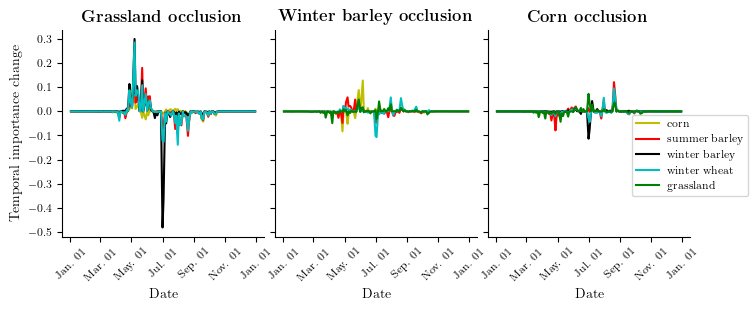

In [4]:
fig_size = set_size(520)
col_order = ["Grassland occlusion", "Winter barley occlusion", "Corn occlusion"]
g = sns.relplot(data=occlusion_changes_dfs,kind="line",
            x="Date", y="Attention Change", col="model_label",
            hue="Crop type", col_order=col_order,
            palette=CROP_TYPE_COLOR_MAPPING)


for i, ax in enumerate(g.axes.flatten()):
    ax.set_title(r'\textbf{{{}}}'.format(col_order[i]))
    ax.xaxis.set_major_formatter(DATE_FORMATTER)
    ax.tick_params(axis='x', rotation=45)
    if i==0:
        ax.set_ylabel('Temporal importance change')

g.legend.remove()
g.fig.legend(handles=g.legend.legendHandles, loc=7)

g.fig.set_figwidth(fig_size[0])
g.fig.set_figheight(2.5)

g.savefig(os.path.join(figures_base_path, 'occlusion_change.pdf'))
g.savefig(os.path.join(figures_base_path, 'occlusion_change.png'), dpi=400)

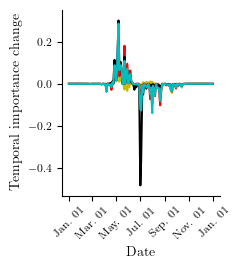

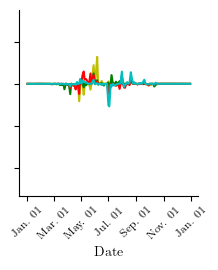

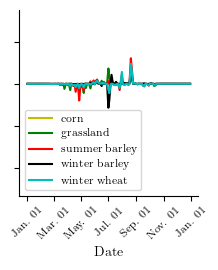

In [11]:
fig_widths = [set_size(180)[0], set_size(165)[0], set_size(165)[0]]
min_change = min(occlusion_changes_dfs["Attention Change"].values)
max_change = max(occlusion_changes_dfs["Attention Change"].values)
occluded_models_labels = occlusion_changes_dfs["model_label"].unique()

legend_handles = []
legend_labels = []

for i, model_label in enumerate(occluded_models_labels):
    fig, ax = plt.subplots(figsize=(fig_widths[i], 2.8))
    
    crop_occlusion_data = occlusion_changes_dfs.loc[occlusion_changes_dfs["model_label"] == model_label]
    ax = sns.lineplot(data=crop_occlusion_data, x="Date", y="Attention Change",
                      hue="Crop type",
                      palette=CROP_TYPE_COLOR_MAPPING, ax=ax)
    ax.xaxis.set_major_formatter(DATE_FORMATTER)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(min_change - 0.05, max_change + 0.05)
    ax.set_ylabel('Temporal importance change')
    
    ax_handles, ax_labels =  ax.get_legend_handles_labels()
    for legend_entry_idx, label in enumerate(ax_labels):
        if label not in legend_labels:
            legend_labels.append(label)
            legend_handles.append(ax_handles[legend_entry_idx])
    
    ax.get_legend().remove()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    if i > 0 & i < (len(occluded_models_labels) - 1):
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i == len(occluded_models_labels) - 1:
        #sort the legend according to the alphabetical order of the crops
        legend_labels_sorted = sorted(legend_labels)
        legend_handles_sorted = [legend_handles[legend_labels.index(x)] for x in sorted(legend_labels)]
        ax.legend(legend_handles_sorted, legend_labels_sorted, loc="best")
    
    fig.tight_layout()
    plt.savefig(os.path.join(figures_base_path, '{}_attn_weights_change.pdf'.format(model_label)), bbox_inches="tight")
